In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES= 0

In [1]:
import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.cross_validation import train_test_split
import random
from keras import backend as K
import keras
from keras.utils import to_categorical
from keras.utils.training_utils import multi_gpu_model
from keras.models import load_model

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

import sys
sys.path.append('keras-deeplab-v3-plus/')
sys.path.append("keras_retinanet")
sys.path.append('/home/jimmy15923/project/monuseg/Mask_RCNN') 

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from deeplab_v3_plus.model import *
from keras_retinanet.losses import *
from keras_retinanet import backend


import cv2
import numpy as np
import os
import random
from skimage import io
from skimage.transform import resize
from skimage import img_as_bool

def read_data_and_split(split_seed, train_ratio, is_normalize=True):
    """read data into np array, normalize it and train test split
    split_seed: set seed for same train test split
    train_ratio: ratio of training set. range from 0 to 1
    is_normalize: True for normalizr to -1 to 1
    
    return np array with x_train, x_test, y_train, y_test
    """
    df = pd.read_csv("/data/jimmy15923/cg_kidney_seg/cgmh_data_list.csv")
    df = df[df.n_mask_pixel > 1000].copy()
    
    idx = df.uid.tolist()
    
#     idx = next(os.walk('/data/jimmy15923/cg_kidney_seg/train'))[1]
#     # remove two file with different size between image & mask
#     idx.remove("S2016-30816_9_0")
#     idx.remove("S2016-30816_9_1")
    
    # set seed
    random.seed(split_seed)
    random.shuffle(idx)
    
    train_idx, test_idx = idx[:int(len(idx)*train_ratio)], idx[int(len(idx)*train_ratio):]

    x_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                    for x in train_idx], dtype="uint8")
    x_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                       for x in test_idx], dtype="uint8")
    
    if is_normalize:
        x_train = (x_train / 127.5) - 1
        x_test = (x_test / 127.5) - 1
        
    y_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                    for x in train_idx])
    
    y_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                        for x in test_idx])
    
    y_train = y_train.astype(np.bool)
    y_test = y_test.astype(np.bool)
    
    return x_train, x_test, y_train, y_test

def cv2_resize(array, size=500, is_bool=False):
    if is_bool:
        return np.array([img_as_bool(resize(x, (size, size))) for x in array])
    return np.array([resize(x, (size,size), preserve_range=True).astype("uint8") for x in array])

size=500
binarize=False

x_train, x_test, y_train, y_test = read_data_and_split(split_seed=7, train_ratio=0.9, is_normalize=False)

x_train = cv2_resize(x_train, size)
x_test = cv2_resize(x_test, size)
y_train = cv2_resize(y_train, size, is_bool=True)
y_test = cv2_resize(y_test, size, is_bool=True)
x_test = (x_test / 127.5) - 1

if binarize:
    y_train = np.expand_dims(y_train, 3)
    y_test = np.expand_dims(y_test, 3)
else:
    y_train = np.stack((~y_train, y_train), axis=3)
    y_test = np.stack((~y_test, y_test), axis=3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2495457849239187189
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10915158426
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16701334635948574293
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


(800, 500, 500, 3)
(89, 500, 500, 3)
(800, 500, 500, 2)
(89, 500, 500, 2)


In [2]:
x_test_plot = ((x_test + 1) * 127.5).astype("uint8")

In [3]:
from deeplab_v3_plus.model import relu6, BilinearUpsampling
model = load_model("/data/jimmy15923/cg_kidney_seg/deeplab_dice.h5",
                           custom_objects={'relu6':relu6, 'BilinearUpsampling':BilinearUpsampling, "focal":focal})

/home/jimmy15923/.local/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
from keras.models import load_model
from keras.utils.training_utils import multi_gpu_model
model = multi_gpu_model(model, gpus=2)

In [ ]:
model.load_weights("/data/jimmy15923/cg_kidney_seg/test_resize.h5")

In [ ]:
model = load_model("/data/jimmy15923/cg_kidney_seg/deeplab_resize_aug.h5")

In [4]:
y_pred = model.predict(x_test)

In [5]:
def IOU_cal(y_true, y_pred):
    iou_res = []
    for i in range(len(y_true)):
        y_true_flat = y_true[i].ravel()
        y_pred_flat = (y_pred[i].ravel() > 0.5) * 1
        intersection = np.sum(y_true_flat * y_pred_flat)
        union = np.sum((y_true_flat+y_pred_flat) - (y_true_flat*y_pred_flat))
        iou = intersection / union
        iou_res.append(iou)
    return iou_res

In [6]:
def IOU(y_true, y_pred, epsilon=1e-6):
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean(numerator / (denominator + epsilon))

In [7]:
def singleImg_calc_iou(y_true, y_pred, is_onehot=False, threshold = 0.5):
    if is_onehot:
        y_true = y_true.argmax(axis = -1)
        y_pred = y_pred.argmax(axis = -1)
    else:
        y_pred[y_pred >= threshold] = 1
        y_pred[y_pred != 1] = 0
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum((y_true+y_pred) - (y_true * y_pred))
    
    iou = intersection / union
    return iou

In [8]:
iou_list = IOU_cal(y_test[:,:,:,1], y_pred[:,:,:,1])

In [9]:
for i in range(0, 101, 10):
    print("IOU of perecentile %i: %.3f" % (i, np.percentile(iou_list,i)))

IOU of perecentile 0: 0.000
IOU of perecentile 10: 0.000
IOU of perecentile 20: 0.337
IOU of perecentile 30: 0.504
IOU of perecentile 40: 0.669
IOU of perecentile 50: 0.772
IOU of perecentile 60: 0.808
IOU of perecentile 70: 0.849
IOU of perecentile 80: 0.880
IOU of perecentile 90: 0.907
IOU of perecentile 100: 0.952


In [9]:
for i in range(0, 101, 10):
    print("IOU of perecentile %i: %.3f" % (i, np.percentile(iou_list3, i)))

IOU of perecentile 0: 0.000
IOU of perecentile 10: 0.000
IOU of perecentile 20: 0.318
IOU of perecentile 30: 0.532
IOU of perecentile 40: 0.682
IOU of perecentile 50: 0.753
IOU of perecentile 60: 0.797
IOU of perecentile 70: 0.858
IOU of perecentile 80: 0.877
IOU of perecentile 90: 0.908
IOU of perecentile 100: 0.948


In [ ]:
np.mean(iou_list3)

38


(-0.5, 499.5, 499.5, -0.5)

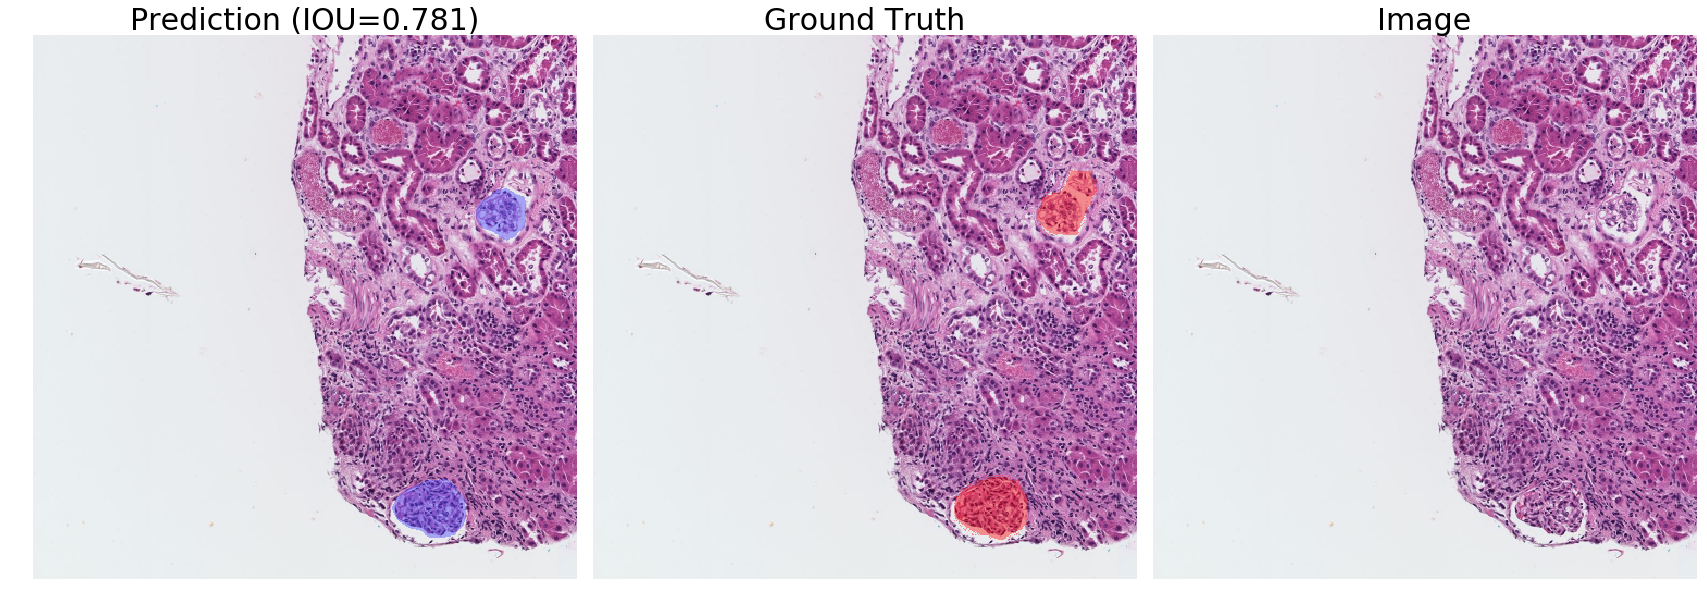

In [40]:
from pylab import rcParams

idx = np.random.choice(len(y_pred))
fig = plt.figure(figsize=(30, 10)) 
fig.subplots_adjust(wspace=0.01, hspace=0)
print(idx)
# idx=69, 44, 50, 64, 183, 162, 3, 34_, 11_, 71_, 35_, 57_
# idx=21
iou = singleImg_calc_iou(y_test[idx][:,:,1], y_pred[idx][:,:,1])
plt.axis("off")
plt.subplot(131)
plt.title("Prediction (IOU={0:.3f})".format(iou), fontsize=30)
res = mask_color_img(x_test_plot[idx], mask= (y_pred[idx][:,:,1] > 0.5), color=[64, 64, 255], alpha=0.4)
plt.imshow(res)
plt.axis("off")
plt.subplot(132)
plt.title("Ground Truth", fontsize=30)
gt = mask_color_img(x_test_plot[idx], mask= (y_test[idx][:,:,1]), color=[255, 0, 0], alpha=0.4)
plt.imshow(gt)
plt.axis("off")
plt.subplot(133)
plt.title("Image", fontsize=30 )
plt.imshow(x_test_plot[idx])
plt.axis("off")
#     plt.savefig("result/seed7_drop1000_idx{}.png".format(str(idx).zfill(2)), dpi=120, bbox_inches='tight', pad_inches = 0)

In [11]:
def mask_color_img(img, mask, color=[255, 0, 0], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

In [ ]:
from tqdm import tqdm_notebook
def bce(y_true, y_pred):
    res = []
    for i in  tqdm_notebook(range(len(y_pred))):
#         ce = -(y_true.ravel() * np.log(y_pred.ravel() + 1e-10))
        ce = log_loss(y_true.ravel(), y_pred.ravel())
        res.append(ce)
    return np.mean(res)